# Import

In [114]:
import os
import cv2
import click
import colorsys
import collections
import dnnlib
import legacy
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image
import re
import random
import tensorflow as tf
import tqdm
import torch
import torchvision.transforms as transforms

from tqdm import trange
from skimage import io, transform
from PIL import Image
from glob import glob
from typing import List, Optional

from tqdm import trange
from data import create_dataset
from models import create_model
from models import networks

from sklearn.cluster import MeanShift
from scipy import ndimage
from mpl_toolkits.mplot3d import Axes3D
# from common import *

# Functions for StylGAN2-ADA
### Following codes are cited from the work "Training Generative Adversarial Networks with Limited Data"

@inproceedings{Karras2020ada,<br>
&emsp;&emsp;  title     = {Training Generative Adversarial Networks with Limited Data},<br>
&emsp;&emsp;  author    = {Tero Karras and Miika Aittala and Janne Hellsten and Samuli Laine and Jaakko Lehtinen and Timo Aila},<br>
&emsp;&emsp;  booktitle = {Proc. NeurIPS},<br>
&emsp;&emsp;  year      = {2020}<br>
}

In [6]:
def num_range(s: str) -> List[int]:
    '''Accept either a comma separated list of numbers 'a,b,c' or a range 'a-c' and return as a list of ints.'''

    range_re = re.compile(r'^(\d+)-(\d+)$')
    m = range_re.match(s)
    if m:
        return list(range(int(m.group(1)), int(m.group(2))+1))
    vals = s.split(',')
    return [int(x) for x in vals]

def generate_images(
    ctx: click.Context,
    network_pkl: str,
    seeds: Optional[List[int]],
    truncation_psi: float,
    noise_mode: str,
    outdir: str,
    class_idx: Optional[int],
    projected_w: Optional[str]
):
    
    print('Loading networks from "%s"...' % network_pkl)
    device = torch.device('cuda')
    with dnnlib.util.open_url(network_pkl) as f:
        G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

    os.makedirs(outdir, exist_ok=True)

    # Synthesize the result of a W projection.
    if projected_w is not None:
        if seeds is not None:
            print ('warn: --seeds is ignored when using --projected-w')
        print(f'Generating images from projected W "{projected_w}"')
        ws = np.load(projected_w)['w']
        ws = torch.tensor(ws, device=device) # pylint: disable=not-callable
        assert ws.shape[1:] == (G.num_ws, G.w_dim)
        for idx, w in enumerate(ws):
            img = G.synthesis(w.unsqueeze(0), noise_mode=noise_mode)
            img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
            img = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/proj{idx:02d}.png')
        return

    if seeds is None:
        ctx.fail('--seeds option is required when not using --projected-w')

    # Labels.
    label = torch.zeros([1, G.c_dim], device=device)
    if G.c_dim != 0:
        if class_idx is None:
            ctx.fail('Must specify class label with --class when using a conditional network')
        label[:, class_idx] = 1
    else:
        if class_idx is not None:
            print ('warn: --class=lbl ignored when running on an unconditional network')

    # Generate images.
    for seed_idx, seed in enumerate(seeds):
        print('Generating image for seed %d (%d/%d) ...' % (seed, seed_idx, len(seeds)))
        z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
        img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/{seed}_0.png')

### Example of generated image

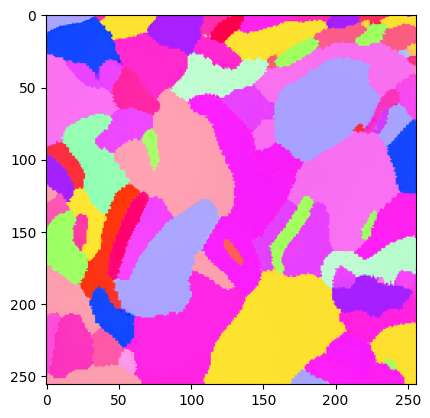

In [16]:
outdir = "results_for_article"
network_pkl = "pretrained/style/generator_weights.pkl"
seeds = [1]
label = None
truncation_psi=1

device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

os.makedirs(outdir, exist_ok=True)

for seed in seeds:
    z_npy = np.random.RandomState(seed).randn(1, G.z_dim)
    # np.save(f"{outdir}/data/{steps}/0.npy", z_npy)
    z = torch.from_numpy(z_npy).to(device)
    
    img = G(z, label, truncation_psi=truncation_psi)
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/{seed}_0.png')
    fig, ax = plt.subplots()
    ax.imshow(PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB'))

# Functions for pix2pix
### Following codes are cited from the work "Image-to-Image Translation with Conditional Adversarial Networks"

@inproceedings{isola2017image,<br>
&emsp;&emsp;  title={Image-to-Image Translation with Conditional Adversarial Networks},<br>
&emsp;&emsp;  author={Isola, Phillip and Zhu, Jun-Yan and Zhou, Tinghui and Efros, Alexei A},<br>
&emsp;&emsp;  booktitle={Computer Vision and Pattern Recognition (CVPR), 2017 IEEE Conference on},<br>
&emsp;&emsp;  year={2017}<br>
}

In [5]:
def load_pix2pix_generator(
    model_file_path: str, gpu_ids: list = [], eval: bool = False
):
    gen = networks.define_G(
        input_nc=3,
        output_nc=3,
        ngf=64,
        netG="unet_256",
        norm="batch",
        use_dropout=True,
        init_type="normal",
        init_gain=0.02,
        gpu_ids=gpu_ids,
    )
    # get device name: CPU or GPU
    # device = (
    #     torch.device("cuda:{}".format(gpu_ids[0])) if gpu_ids else torch.device("cpu")
    # )
    device = "cpu"

    # if you are using PyTorch newer than 0.4, you can remove str() on self.device
    state_dict = torch.load(model_file_path, map_location=str(device))
    if hasattr(state_dict, "_metadata"):
        del state_dict._metadata
    gen.load_state_dict(state_dict)

    # dropout and batchnorm has different behavioir during training and test.
    if eval:
        gen.eval()
    return gen

# def translate(img: np.ndarray, model: torch.nn.Module, device: torch.device):
def translate(img: np.ndarray, model: torch.nn.Module):
    from PIL import Image
    img_p = Image.fromarray(img).convert("RGB")
    tr = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    device = ('cpu')
    fake = model(tr(img_p).to(device).view(1,3,256,256))
    # with torch.no_grad():
    #     fake = (
    #         model(tr(img_p).to(device).view(1,3,256,256))
    #         .detach()
    #         .cpu()
    #         .numpy()
    #     ).reshape(img.shape)
    return fake

def tensor2im(input_image, imtype=np.uint8):
    """"Converts a Tensor array into a numpy image array.

    Parameters:
        input_image (tensor) --  the input image tensor array
        imtype (type)        --  the desired type of the converted numpy array
    """
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):  # get the data from a variable
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor[0].cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0  # post-processing: tranpose and scaling
    else:  # if it is a numpy array, do nothing
        image_numpy = input_image
    return image_numpy.astype(imtype)

### Example results

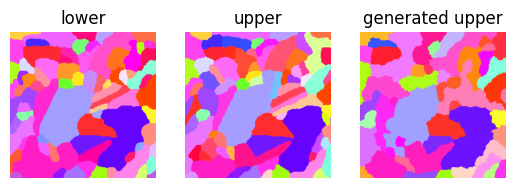

In [109]:
netG = load_pix2pix_generator("pretrained/pix2pix/latest_net_G.pth")
lower, upper = io.imread("pretrained/pix2pix/lower.png"), io.imread("pretrained/pix2pix/upper.png")
tensor_image = translate(lower, netG)
out = tensor2im(tensor_image)
out = crystal_orientation_averaging(out)
io.imsave("pretrained/pix2pix/generated_upper.png", out)
fig, ax = plt.subplots(ncols=3)
ax[0].imshow(lower)
ax[0].set_title('lower')
ax[0].axis("off");
ax[1].imshow(upper)
ax[1].set_title('upper')
ax[1].axis("off");
ax[2].imshow(out)
ax[2].set_title('generated upper')
ax[2].axis("off");

# StyleGAN2-ADA + pix2pix

In [101]:
outdir = "results_for_article"
network_pkl = "pretrained/style/generator_weights.pkl"
pix2pix_weights = "pretrained/pix2pix/latest_net_G.pth"
seeds = [1]
num_layers = 3
label = None
truncation_psi=1

# load models
# StyleGAN2-ADA
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

# pix2pix
netG = load_pix2pix_generator(pix2pix_weights)

os.makedirs(outdir, exist_ok=True)

for seed in seeds:
    os.makedirs(f'{outdir}/{seed}_3D', exist_ok=True)
    z_npy = np.random.RandomState(seed).randn(1, G.z_dim)
    # np.save(f"{outdir}/data/{steps}/0.npy", z_npy)
    z = torch.from_numpy(z_npy).to(device)
    
    img = G(z, label, truncation_psi=truncation_psi)
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/{seed}_bottom.png')
    img = io.imread(f'{outdir}/{seed}_bottom.png')
    img = crystal_orientation_averaging(img)
    io.imsave(f'{outdir}/{seed}_3D/{seed}_0.png', img)
    
    for layer in range(num_layers):
        lower = io.imread(f'{outdir}/{seed}_{layer}.png')
        tensor_image = translate(lower, netG)
        gen_upper = tensor2im(tensor_image)
        gen_upper = crystal_orientation_averaging(gen_upper)
        io.imsave(f'{outdir}/{seed}_3D/{seed}_{layer+1}.png', gen_upper)

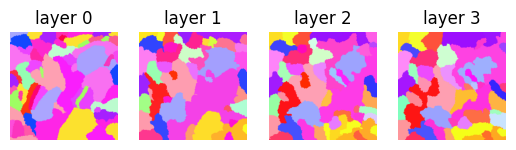

In [107]:
for seed in seeds:
    fig, ax = plt.subplots(ncols=num_layers+1)
    for layer in range(num_layers + 1):
        ax[layer].imshow(io.imread(f'{outdir}/{seed}_{layer}.png'))
        ax[layer].set_title(f'layer {layer}')
        ax[layer].axis("off");

# Stack generated images
### Functions

In [119]:
def load_images(img_path):
    images = []
    files = os.listdir(img_path)
    for file in files:
        img = Image.open(f"{img_path}/{file}").convert('RGB')
        images.append(np.array(img))
        image_nu = np.array(images)
    return image_nu

def stack_images(images):
    return np.stack(images, axis=0)
    
# 3D voxel
def plot_3d_image_stack(stack, out_path):
    fig = plt.figure(figsize=(10, 10), dpi=200)
    ax = fig.add_subplot(111, projection='3d')
    x, y , z, c = stack.shape
    print('stack:', stack.shape)
    
    # RGBA matrix
    ones_array = np.ones((x, y, z, 1), dtype=np.float32)
    normalized_stack = stack.astype(np.float32) / 255.0
    stack_color = np.concatenate((normalized_stack, ones_array), axis=3)
    print('color:', stack_color.shape)
    
    # display voxels
    ax.voxels(np.ones(stack.shape[:3], dtype=bool), facecolors=stack_color, edgecolor=None, alpha=None)
    
    ax.set_xlim(0, x)
    ax.set_ylim(0, y)
    #ax.set_xlim(200, 300)
    #ax.set_ylim(200, 300)
    ax.set_zlim(0, 10)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.setp(ax.get_zticklabels(), visible=False) 
    ax.axis("off")

    plt.show()
    ax.figure.savefig(out_path)

---load_image:start---
(4, 256, 256, 3)
---load_image:Done---

---stack_image:start---
(4, 256, 256, 3)
---stack_image:Done---

---trim_image:start---
(256, 256, 4, 3)
---trim_image:Done---

---3D_plot---
stack: (256, 256, 4, 3)
color: (256, 256, 4, 4)


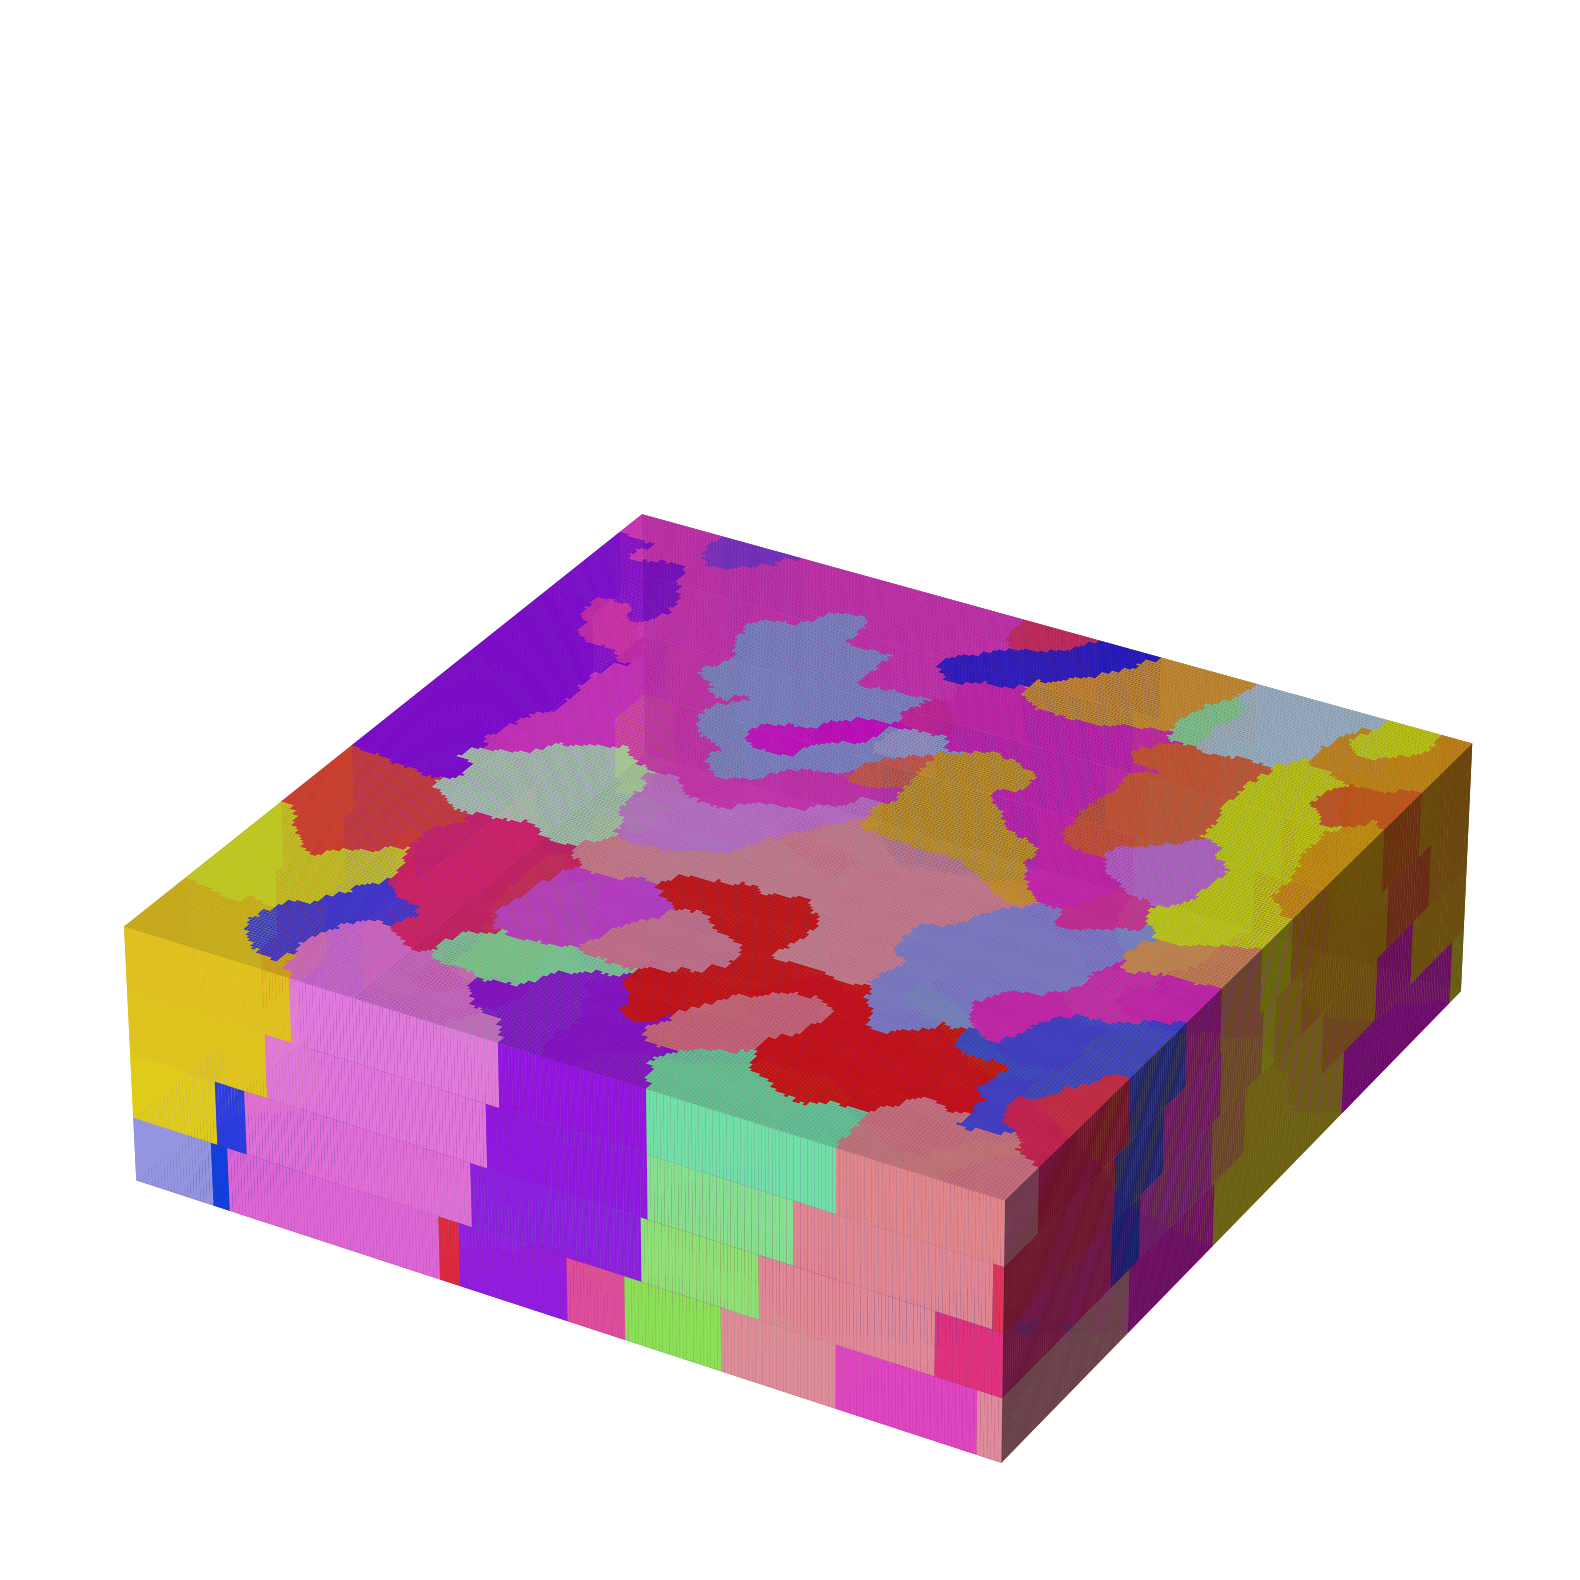

In [120]:
for seed in seeds:
    with tf.device('/GPU:0'):
        img_path = f"D:/deshi/for_paper/3D-model-generation/results_for_article/{seed}_3D"
        print('---load_image:start---')
        images = load_images(img_path)
        print(images.shape)
        print('---load_image:Done---'  )
    
        print('\n---stack_image:start---')
        image_stack = stack_images(images)
        print(image_stack.shape)
        print('---stack_image:Done---'  )
    
        print('\n---trim_image:start---')
        image_stack_trim = image_stack.copy()
        image_stack_trim = image_stack_trim.transpose(1, 2, 0, 3)
        print(image_stack_trim.shape)
        print('---trim_image:Done---')
    
        print('\n---3D_plot---')
        plot_3d_image_stack(image_stack_trim, f"D:/deshi/for_paper/3D-model-generation/results_for_article/{seed}_3D.png")